#### 이미지 전처리

In [4]:
N_CLASSES =43
RESIZED_IMAGE=(32,32)

import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import glob

Using TensorFlow backend.


In [5]:
from collections import namedtuple

In [66]:
dataset = namedtuple('dataset', ['X', 'y'])

def read_dataset_ppm(rootpath, number_labels, resize_to):
    
    images = np.array([])
    labels = np.array([])
    imgcnt = 0
    resizeimg = []
    
    for c in range(number_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        print(full_path)
        for img_name in glob.glob(full_path + "*.ppm"):
            
            _image = load_img(img_name)
            _image_small = load_img(img_name, target_size=RESIZED_IMAGE, grayscale=True)
            x = img_to_array(_image_small)
            x = np.expand_dims(x, axis=0)
            images_vector = np.reshape(x, (1,-1))
            current_lebel = np.eye(N_CLASSES, N_CLASSES)[c:c+1,:]
            
            if len(images) is 0:
                images = images_vector
                labels = current_lebel
                
            images = np.concatenate((images, images_vector), axis= 0)
            labels = np.concatenate((labels, current_lebel), axis=0)
            
#         print(f'current path: ${full_path}, \n count: {len(images)}, \n labels {labels}')
        
    return dataset(X=images, y=labels)

current_directory = os.getcwd()
dataset = read_dataset_ppm(current_directory + '/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00000/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00001/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00002/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00003/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00004/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00005/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00006/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00007/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00008/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00009/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00010/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00011/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00012/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00013/
/Users/len/Show-me-the-data-science/88.kaggle/gtsrb/Images/00014/
/Users/len

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


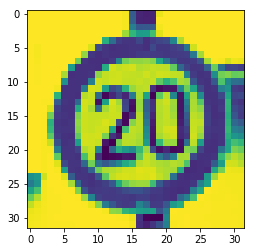

In [100]:
plt.imshow(dataset.X[1].reshape(RESIZED_IMAGE))
print(dataset.y[0,:])

In [113]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train]
X_test = dataset.X[idx_test]
y_train = dataset.y[idx_train]
y_test = dataset.y[idx_test]

print(X_train.shape)
print(y_train.shape)


print(X_test.shape)
print(y_test.shape)


(29407, 1024)
(29407, 43)
(9803, 1024)
(9803, 43)


## 모델 정의

In [102]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [108]:
image_size = [32,32] # 244,244 가로 세로 채널 1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(32, 32, 1), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [115]:
from keras.utils import to_categorical
import keras

trainimg = np.reshape(X_train, (X_train.shape[0], 32, 32,1)).astype('float32') / 255.
# testimg = to_categorical(y_train, N_CLASSES)

X_test = np.reshape(X_test, (X_test.shape[0], 32, 32,1)).astype('float32') / 255.
# y_test = to_categorical(y_test, N_CLASSES)
# trainlabel = to_categorical(trainlabel, nclass)
# testlabel = to_categorical(testlabel, nclass)

print("-----------------")
print(trainimg.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)
print("-----------------")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x=trainimg, y=y_train, 
                    epochs=30, 
                    batch_size=50, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_callback, checkpointer])

# 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

-----------------
(29407, 32, 32, 1)
(29407, 43)
(9803, 32, 32, 1)
(9803, 43)
-----------------
Train on 29407 samples, validate on 9803 samples
Epoch 1/30
 9400/29407 [========>.....................] - ETA: 123s - loss: 3.1057 - acc: 0.2006

KeyboardInterrupt: 